# 1. Imports


In [1]:
print("\n... PIP INSTALLS STARTING ...\n")
!pip install -q --upgrade tensorflow-io
try:
    import mediapipe as mp
except:
    !pip install -q mediapipe
    import mediapipe as mp
print("\n... PIP INSTALLS COMPLETE ...\n")


print("\n... IMPORTS STARTING ...\n")
print("\n\tVERSION INFORMATION")
# Competition Specific Imports (You'll see why we need these later)
# mediapipe above

# Machine Learning and Data Science Imports (basics)
import tensorflow as tf; print(f"\t\t– TENSORFLOW VERSION: {tf.__version__}");
import tensorflow_io as tfio; print(f"\t\t– TENSORFLOW-IO VERSION: {tfio.__version__}");
import pandas as pd; pd.options.mode.chained_assignment = None; pd.set_option('display.max_columns', None);
import numpy as np; print(f"\t\t– NUMPY VERSION: {np.__version__}");
import sklearn; print(f"\t\t– SKLEARN VERSION: {sklearn.__version__}");

# Built-In Imports (mostly don't worry about these)
from kaggle_datasets import KaggleDatasets
from collections import Counter
from datetime import datetime
from zipfile import ZipFile
from glob import glob
import Levenshtein
import warnings
import requests
import hashlib
import imageio
import IPython
import sklearn
import urllib
import zipfile
import pickle
import random
import shutil
import string
import json
import math
import time
import gzip
import ast
import sys
import io
import os
import gc
import re

# Visualization Imports (overkill)
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import plotly.graph_objects as go
from IPython.display import HTML
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
import tifffile as tif
import seaborn as sns
from PIL import Image, ImageEnhance; Image.MAX_IMAGE_PIXELS = 5_000_000_000;
import matplotlib; print(f"\t\t– MATPLOTLIB VERSION: {matplotlib.__version__}");
from matplotlib import animation, rc; rc('animation', html='jshtml')
import plotly
import PIL
import cv2

import plotly.io as pio
print(pio.renderers)

def seed_it_all(seed=7):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()

print("\n\n... IMPORTS COMPLETE ...\n")


... PIP INSTALLS STARTING ...

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.

... PIP INSTALLS COMPLETE ...


... IMPORTS STARTING ...


	VERSION INFORMATION
		– TENSORFLOW VERSION: 2.11.0
		– TENSORFLOW-IO VERSION: 0.31.0
		– NUMPY VERSION: 1.21.6
		– SKLEARN VERSION: 1.0.2
		– MATPLOTLIB VERSION: 3.5.3
Renderers configuration
-----------------------
    Default renderer: 'kaggle'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
        

In [2]:
train_x    = np.load("/kaggle/input/gislr-hand-features/feature_data_16march.npy").astype(np.float32)
train_y    = np.load("/kaggle/input/gislr-hand-features/feature_labels_16march.npy").astype(np.uint8)
BATCH_SIZE = 64
N_TOTAL = train_x.shape[0]
VAL_PCT = 0.1
N_VAL   = int(N_TOTAL*VAL_PCT)
N_TRAIN = N_TOTAL-N_VAL

random_idxs = random.sample(range(N_TOTAL), N_TOTAL)
train_idxs, val_idxs = np.array(random_idxs[:N_TRAIN]), np.array(random_idxs[N_TRAIN:])

val_x, val_y = train_x[val_idxs], train_y[val_idxs]
train_x, train_y = train_x[train_idxs], train_y[train_idxs]

# train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))\
#                           .shuffle(N_TRAIN)\
#                           .batch(BATCH_SIZE, drop_remainder=True)\
#                           .prefetch(tf.data.AUTOTUNE)

# val_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))\
#                           .shuffle(N_VAL)\
#                           .batch(BATCH_SIZE, drop_remainder=True)\
#                           .prefetch(tf.data.AUTOTUNE)

# train_ds, val_ds

In [3]:
print(val_x.shape)

(9447, 920)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 920)]             0         
                                                                 
 dense (Dense)               (None, 512)               471552    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                             

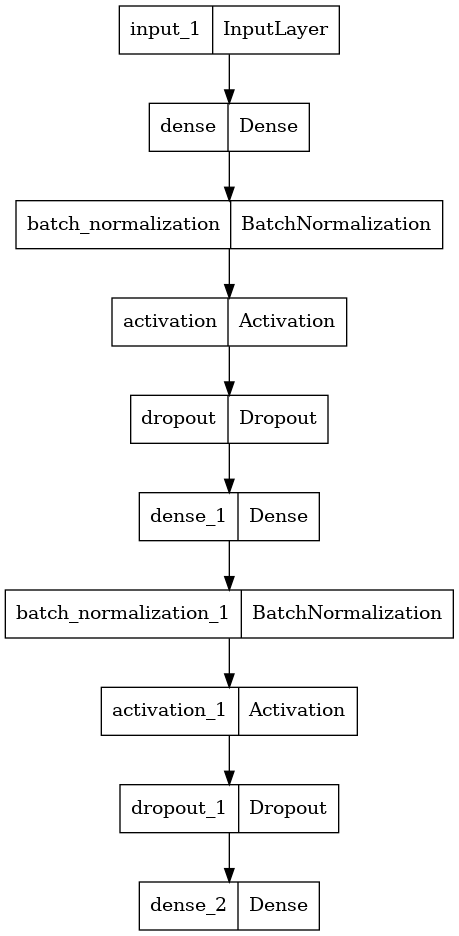

In [4]:
def fc_block(inputs, output_channels, dropout=0.2):
    x = tf.keras.layers.Dense(output_channels)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("gelu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    return x

def get_model(n_labels=250, init_fc=512, n_blocks=2, _dropout_1=0.2, _dropout_2=0.6, flat_frame_len=920):
    _inputs = tf.keras.layers.Input(shape=(flat_frame_len,))
    x = _inputs
    
    # Define layers
    for i in range(n_blocks):
        x = fc_block(
            x, output_channels=init_fc//(2**i), 
            dropout=_dropout_1 if (1+i)!=n_blocks else _dropout_2
        )
    
    # Define output layer
    _outputs = tf.keras.layers.Dense(n_labels, activation="softmax")(x)
    
    # Build the model
    model = tf.keras.models.Model(inputs=_inputs, outputs=_outputs)
    return model

model = get_model()
model.compile(tf.keras.optimizers.Adam(0.000333), "sparse_categorical_crossentropy", metrics="acc")
model.summary()

tf.keras.utils.plot_model(model)

In [5]:
!mkdir models
cb_list = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.8, verbose=1)
]
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=2, callbacks=cb_list, batch_size=BATCH_SIZE)
model.save("./models/asl_base_model")

Epoch 1/2
1329/1329 [==============================] - 12s 5ms/step - loss: 5.5499 - acc: 0.0103 - val_loss: 5.1838 - val_acc: 0.0257 - lr: 3.3300e-04
Epoch 2/2
1329/1329 [==============================] - 7s 5ms/step - loss: 4.9704 - acc: 0.0382 - val_loss: 4.5367 - val_acc: 0.0939 - lr: 3.3300e-04


In [6]:
def read_json_file(file_path):
    """Read a JSON file and parse it into a Python object.

    Args:
        file_path (str): The path to the JSON file to read.

    Returns:
        dict: A dictionary object representing the JSON data.
        
    Raises:
        FileNotFoundError: If the specified file path does not exist.
        ValueError: If the specified file path does not contain valid JSON data.
    """
    try:
        # Open the file and load the JSON data into a Python object
        with open(file_path, 'r') as file:
            json_data = json.load(file)
        return json_data
    except FileNotFoundError:
        # Raise an error if the file path does not exist
        raise FileNotFoundError(f"File not found: {file_path}")
    except ValueError:
        # Raise an error if the file does not contain valid JSON data
        raise ValueError(f"Invalid JSON data in file: {file_path}")

In [7]:
# Define the path to the root data directory
DATA_DIR         = "/kaggle/input/asl-signs"
EXTEND_TRAIN_DIR = "/kaggle/input/gislr-extended-train-dataframe" 

print("\n... BASIC DATA SETUP STARTING ...\n")
print("\n\n... LOAD TRAIN DATAFRAME FROM CSV FILE ...\n")

LOAD_EXTENDED = True
if LOAD_EXTENDED and os.path.isfile(os.path.join(EXTEND_TRAIN_DIR, "extended_train.csv")):
    train_df = pd.read_csv(os.path.join(EXTEND_TRAIN_DIR, "extended_train.csv"))
else:
    train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
    train_df["path"] = DATA_DIR+"/"+train_df["path"]
# display(train_df)

print("\n\n... LOAD SIGN TO PREDICTION INDEX MAP FROM JSON FILE ...\n")
s2p_map = {k.lower():v for k,v in read_json_file(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json")).items()}
p2s_map = {v:k for k,v in read_json_file(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json")).items()}
encoder = lambda x: s2p_map.get(x.lower())
decoder = lambda x: p2s_map.get(x)


... BASIC DATA SETUP STARTING ...



... LOAD TRAIN DATAFRAME FROM CSV FILE ...



... LOAD SIGN TO PREDICTION INDEX MAP FROM JSON FILE ...



In [8]:
model.evaluate(val_x, val_y)
for x,y in zip(val_x[:10], val_y[:10]):
    print(f"PRED: {decoder(np.argmax(model.predict(tf.expand_dims(x, axis=0), verbose=0), axis=-1)[0]):<20} – GT: {decoder(y)}")

296/296 [==============================] - 1s 3ms/step - loss: 4.5367 - acc: 0.0939
PRED: wet                  – GT: all
PRED: cowboy               – GT: better
PRED: bug                  – GT: bug
PRED: bath                 – GT: horse
PRED: please               – GT: animal
PRED: man                  – GT: ear
PRED: tree                 – GT: airplane
PRED: weus                 – GT: arm
PRED: vacuum               – GT: beside
PRED: grandpa              – GT: pretend


In [9]:
ROWS_PER_FRAME = 543  # number of landmarks per frame
def load_relevant_data_subset(pq_path):
#     data_columns = ['x', 'y', 'z']
    data_columns = ['x', 'y']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [10]:
class FeatureGen(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureGen, self).__init__()
        self.SEGMENTS = 20
        self.right_hand_landmarks = [i for i in range(522,543)]
        self.left_hand_landmarks = [i for i in range(468,489)]
        self.averaging_sets = [[0, 468], [489, 33]]
    
    def tf_nan_mean(self,x, axis=0):
        return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis)

    def tf_nan_std(self,x, axis=0):
        d = x - tf_nan_mean(x, axis=axis)
        return tf.math.sqrt(tf_nan_mean(d * d, axis=axis))

    def flatten_means_and_stds(self,x, axis=0):
        in_shape = x.shape[1]
        x_mean = self.tf_nan_mean(x, axis=0)
        x_out = tf.concat([x_mean], axis=0)
        x_out = tf.reshape(x_out, (1, in_shape*2))
        x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
        return x_out
    
    def non_nan_handlndmk(self,rhpt):
        if rhpt>0.5:
            point_landmarks = [item for sublist in [self.right_hand_landmarks] for item in sublist]
        else :
            point_landmarks = [item for sublist in [self.left_hand_landmarks] for item in sublist]
        return point_landmarks
    
    def call(self, x_in):
        right = tf.gather(x_in, self.right_hand_landmarks, axis=1)
        left = tf.gather(x_in, self.left_hand_landmarks, axis=1)
        right_count = tf.reduce_sum(tf.where(tf.math.is_nan(right), tf.zeros_like(right), tf.ones_like(right)))
        left_count = tf.reduce_sum(tf.where(tf.math.is_nan(left), tf.zeros_like(left), tf.ones_like(left)))
        rhpt = right_count / (left_count+right_count)
        
        x_list = [tf.expand_dims(self.tf_nan_mean(x_in[:, av_set[0]:av_set[0]+av_set[1], :], 1), axis=1) for av_set in self.averaging_sets]
        x_list.append(tf.gather(x_in,self.non_nan_handlndmk(rhpt),axis=1))
        x = tf.concat(x_list, 1)
        x_padded = x
#         if (x.shape[0]==None):
#             no_pads = 0
#         else:
#             no_pads = self.SEGMENTS - x.shape[0]%self.SEGMENTS
        no_pads = self.SEGMENTS - x.shape[0]%self.SEGMENTS
        paddings = [[no_pads//2, no_pads-no_pads//2], [0, 0], [0, 0]]
        x_padded = tf.pad(x_padded, paddings, mode="Constant",constant_values=0)
        x_list = tf.split(x_padded, self.SEGMENTS)
        x_l = [self.flatten_means_and_stds(_x, axis=0) for _x in x_list]
        x = tf.concat(x_l, axis=1)
        return x

feature_converter = FeatureGen()
# FeatureGen()(tf.convert_to_tensor(load_relevant_data_subset(train_df.path[0])))

In [17]:
# FeatureGen()(load_relevant_data_subset(train_df.path[0]))

In [12]:
train_df.path[0]
load_relevant_data_subset(train_df.path[0]).shape

(23, 543, 2)

In [41]:
import tensorflow as tf

class TFLiteModel(tf.Module):
    """
    TensorFlow Lite model that takes input tensors and applies:
        – a preprocessing model
        – the ISLR model 
    """

    def __init__(self, islr_model ):
        """
        Initializes the TFLiteModel with the specified preprocessing model and ISLR model.
        """
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.prep_inputs = FeatureGen()
        self.islr_model   = islr_model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[11, 543, 2], dtype=tf.float32, name='inputs')])
#     @tf.function()
    def __call__(self, inputs):
        """
        Applies the feature generation model and main model to the input tensors.

        Args:
            inputs: Input tensor with shape [batch_size, 543, 3].

        Returns:
            A dictionary with a single key 'outputs' and corresponding output tensor.
        """
#         print('test1')
        x = self.prep_inputs(tf.cast(inputs, dtype=tf.float32))
#         print(x.shape)
#         print('test2')
        outputs = self.islr_model(x)[0, :]

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

tflite_keras_model = TFLiteModel(islr_model=model)
# demo_output = tflite_keras_model(load_relevant_data_subset(train_df.path[11]))["outputs"]
# decoder(np.argmax(demo_output.numpy(), axis=-1))

In [42]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
tflite_model = keras_model_converter.convert()
with open('/kaggle/working/models/model.tflite', 'wb') as f:
    f.write(tflite_model)
!zip submission.zip /kaggle/working/models/model.tflite

!pip install tflite-runtime
import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("/kaggle/working/models/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
# if REQUIRED_SIGNATURE not in found_signatures:
#     raise KernelEvalException('Required input signature not found.')
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=load_relevant_data_subset(train_df.path[10]))
sign = np.argmax(output["outputs"])

print("PRED : ", decoder(sign))
print("GT   : ", train_df.sign[0])

updating: kaggle/working/models/model.tflite (deflated 12%)


NameError: name 'REQUIRED_SIGNATURE' is not defined